# 🏠 DESAFIO: ANALISANDO DADOS DE PREÇOS DE CASAS NOS ESTADOS UNIDOS

## 🔍 1. Análise Exploratória de Dados e Feature Engineering

### 📚 Carregamento de Bibliotecas e Dados
```python

In [1]:
# Bibliotecas de terceiros
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

# Estatística e testes estatísticos
from scipy.stats import f_oneway, levene, shapiro

# Scikit-learn - Pré-processamento e transformação
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler

# Scikit-learn - Modelos e avaliação
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_squared_error,
    silhouette_score
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import LocalOutlierFactor

# mlxtend - Regras de associação
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

###  📂 Exploração Inicial dos Dados

In [2]:
train = pd.read_csv('train.csv')
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 🧮 Identificação de Variáveis e Valores Faltantes

In [4]:
# Identificar colunas numéricas e categóricas
num_cols = train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = train.select_dtypes(include=["object", "category"]).columns.tolist()

# Calcular valores faltantes
missing_values = train.isnull().sum()
missing_percentage = (missing_values / len(train)) * 100
missing_data = missing_values[missing_values > 0]

# Exibir variáveis numéricas
print("\nVariáveis Numéricas:")
if num_cols:
    for col in num_cols:
        print(f"  - {col}")
else:
    print("  (Nenhuma)")

# Exibir variáveis categóricas
print("\nVariáveis Categóricas:")
if cat_cols:
    for col in cat_cols:
        print(f"  - {col}")
else:
    print("  (Nenhuma)")

# Exibir valores faltantes
print("\nValores Faltantes:")
if not missing_data.empty:
    for col in missing_data.index:
        val = missing_values[col]
        perc = missing_percentage[col]
        print(f"  - {col}: {val} valores faltantes ({perc:.2f}%)")
else:
    print("  (Nenhum valor faltante)")


Variáveis Numéricas:
  - Id
  - MSSubClass
  - LotFrontage
  - LotArea
  - OverallQual
  - OverallCond
  - YearBuilt
  - YearRemodAdd
  - MasVnrArea
  - BsmtFinSF1
  - BsmtFinSF2
  - BsmtUnfSF
  - TotalBsmtSF
  - 1stFlrSF
  - 2ndFlrSF
  - LowQualFinSF
  - GrLivArea
  - BsmtFullBath
  - BsmtHalfBath
  - FullBath
  - HalfBath
  - BedroomAbvGr
  - KitchenAbvGr
  - TotRmsAbvGrd
  - Fireplaces
  - GarageYrBlt
  - GarageCars
  - GarageArea
  - WoodDeckSF
  - OpenPorchSF
  - EnclosedPorch
  - 3SsnPorch
  - ScreenPorch
  - PoolArea
  - MiscVal
  - MoSold
  - YrSold
  - SalePrice

Variáveis Categóricas:
  - MSZoning
  - Street
  - Alley
  - LotShape
  - LandContour
  - Utilities
  - LotConfig
  - LandSlope
  - Neighborhood
  - Condition1
  - Condition2
  - BldgType
  - HouseStyle
  - RoofStyle
  - RoofMatl
  - Exterior1st
  - Exterior2nd
  - MasVnrType
  - ExterQual
  - ExterCond
  - Foundation
  - BsmtQual
  - BsmtCond
  - BsmtExposure
  - BsmtFinType1
  - BsmtFinType2
  - Heating
  - Heating

### 📊 Visualização das Distribuições

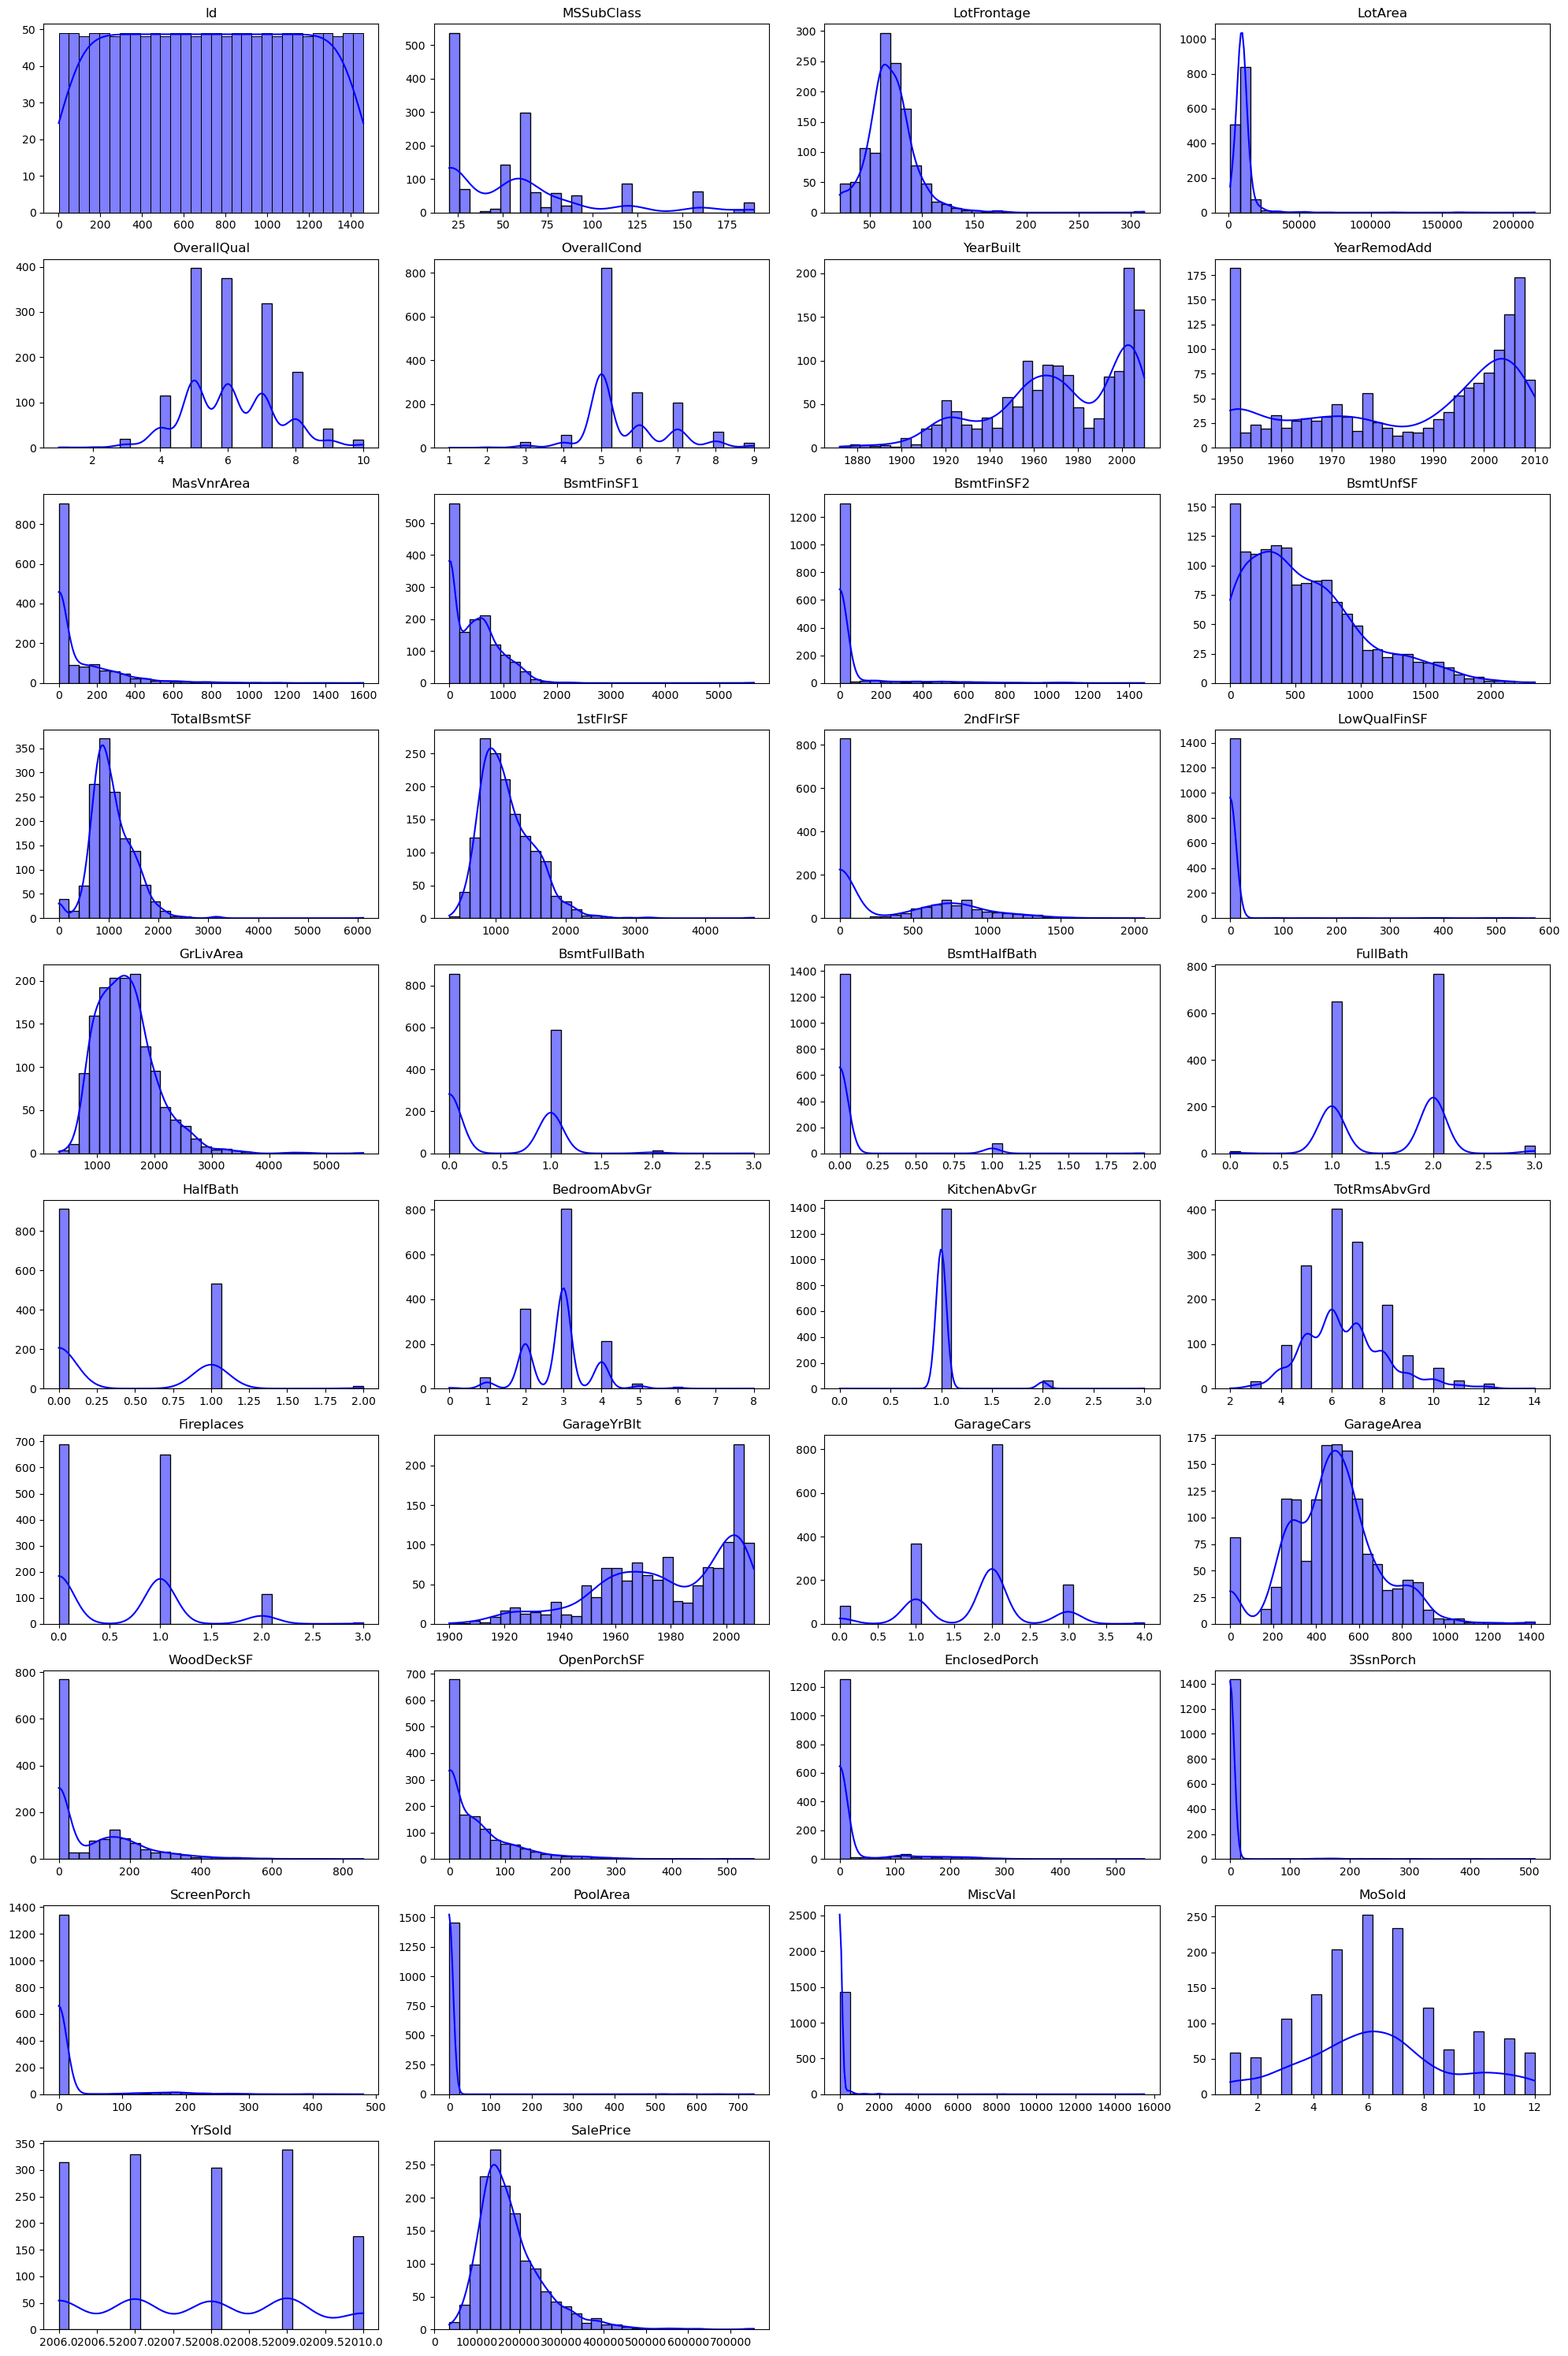


Estatísticas para a coluna 'Id':
count    1460.000000
mean      730.500000
std       421.610009
min         1.000000
25%       365.750000
50%       730.500000
75%      1095.250000
max      1460.000000
Name: Id, dtype: float64

Estatísticas para a coluna 'MSSubClass':
count    1460.000000
mean       56.897260
std        42.300571
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

Estatísticas para a coluna 'LotFrontage':
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

Estatísticas para a coluna 'LotArea':
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

Estatísticas para a coluna 'Ove

In [5]:
# Plotar histogramas das variáveis numéricas
plt.figure(figsize=(20, 30))

for i, col in enumerate(num_cols):
    plt.subplot(10, 4, i + 1)
    sns.histplot(train[col], kde=True, bins=30, color='blue')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

plt.show()

# Exibir estatísticas descritivas das variáveis numéricas
for col in num_cols:
    stats = train[col].describe()
    print(f"\nEstatísticas para a coluna '{col}':")
    print(stats)

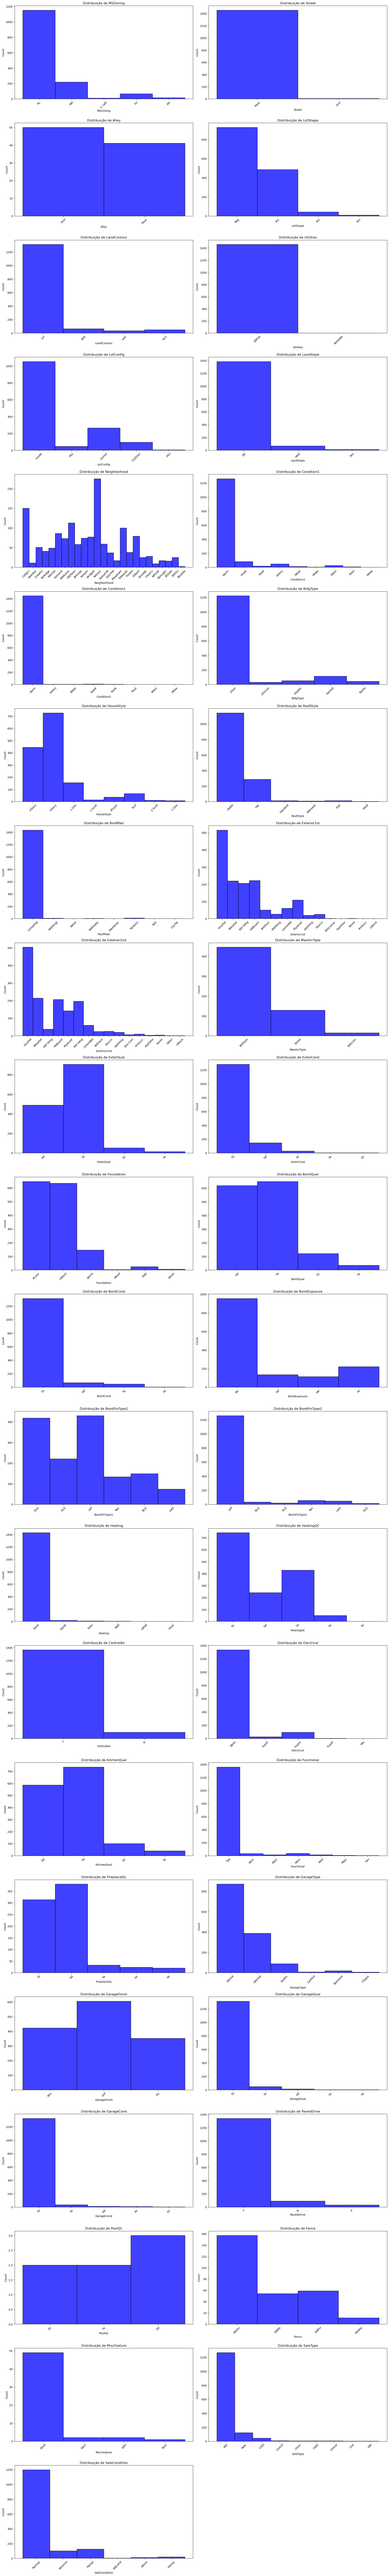


Estatísticas para coluna 'MSZoning':
count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

Estatísticas para coluna 'Street':
count     1460
unique       2
top       Pave
freq      1454
Name: Street, dtype: object

Estatísticas para coluna 'Alley':
count       91
unique       2
top       Grvl
freq        50
Name: Alley, dtype: object

Estatísticas para coluna 'LotShape':
count     1460
unique       4
top        Reg
freq       925
Name: LotShape, dtype: object

Estatísticas para coluna 'LandContour':
count     1460
unique       4
top        Lvl
freq      1311
Name: LandContour, dtype: object

Estatísticas para coluna 'Utilities':
count       1460
unique         2
top       AllPub
freq        1459
Name: Utilities, dtype: object

Estatísticas para coluna 'LotConfig':
count       1460
unique         5
top       Inside
freq        1052
Name: LotConfig, dtype: object

Estatísticas para coluna 'LandSlope':
count     1460
unique       3
top        Gtl
freq

In [6]:
num_cat_cols = len(cat_cols)
num_rows = (num_cat_cols // 2) + (num_cat_cols % 2)
plt.figure(figsize=(20, num_rows * 6))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(num_rows, 2, i)
    sns.histplot(x=col, data=train, color='blue')
    plt.title(f'Distribuição de {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

summary_categorical = {}
for col in cat_cols:
    summary_categorical[col] = train[col].describe()

for col, stats in summary_categorical.items():
    print(f"\nEstatísticas para coluna '{col}':\n{stats}")

### 🔗 Análise de Correlações

In [7]:
correlations = train[num_cols].corr()['SalePrice'].sort_values(ascending=False)

top_correlations = correlations.head(11)
print("Top 10 correlações com SalePrice:\n", top_correlations)

bottom_correlations = correlations.tail(10)
print("\nBottom 10 correlações com SalePrice:\n", bottom_correlations)

Top 10 correlações com SalePrice:
 SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

Bottom 10 correlações com SalePrice:
 BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


### 🧪 Testes Estatísticos

In [8]:
# Lista para armazenar os resultados da ANOVA
anova_results = []

# Executar ANOVA para cada variável categórica
for col in cat_cols:
    categories = train[col].dropna().unique()  # Ignora valores nulos
    
    # Garante que cada grupo tenha pelo menos 2 valores em SalePrice
    grupos_validos = [
        train[train[col] == categoria]['SalePrice']
        for categoria in categories
        if train[train[col] == categoria]['SalePrice'].count() > 1
    ]

    if len(grupos_validos) >= 2:
        try:
            anova = f_oneway(*grupos_validos)
            anova_results.append((col, anova.statistic, anova.pvalue))
        except Exception as e:
            print(f"Erro ao calcular ANOVA para '{col}': {e}")

# Criar DataFrame com os resultados
df_anova = pd.DataFrame(anova_results, columns=['Variável Categórica', 'F-statistic', 'p-value'])

# Ordenar pelo p-value (quanto menor, maior evidência de diferença entre grupos)
df_anova.sort_values(by='p-value', ascending=True, inplace=True)

# Top 10 variáveis com maior correlação com SalePrice segundo ANOVA
print("\nTop 10 variáveis com maior relação com 'SalePrice' (menor p-value):")
print(df_anova.head(10))

# Bottom 10 variáveis (menor evidência de diferença entre grupos)
print("\nBottom 10 variáveis com menor relação com 'SalePrice' (maior p-value):")
print(df_anova.tail(10))



Top 10 variáveis com maior relação com 'SalePrice' (menor p-value):
   Variável Categórica  F-statistic        p-value
7         Neighborhood    71.784865  1.558600e-225
17           ExterQual   443.334831  1.439551e-204
29         KitchenQual   407.806352  3.032213e-192
20            BsmtQual   392.913506  9.610615e-186
33        GarageFinish   250.962467   1.199117e-93
19          Foundation   100.253851   5.791895e-91
26           HeatingQC   117.281347   5.041729e-68
32          GarageType    71.522123   1.247154e-66
23        BsmtFinType1    67.602175   1.807731e-63
14         Exterior1st    23.369586   1.255003e-44

Bottom 10 variáveis com menor relação com 'SalePrice' (maior p-value):
   Variável Categórica  F-statistic   p-value
5            LotConfig     7.809954  0.000003
30          Functional     4.782886  0.000243
25             Heating     4.853595  0.000686
38               Fence     4.948159  0.002313
24        BsmtFinType2     2.702450  0.019410
9           Condition2

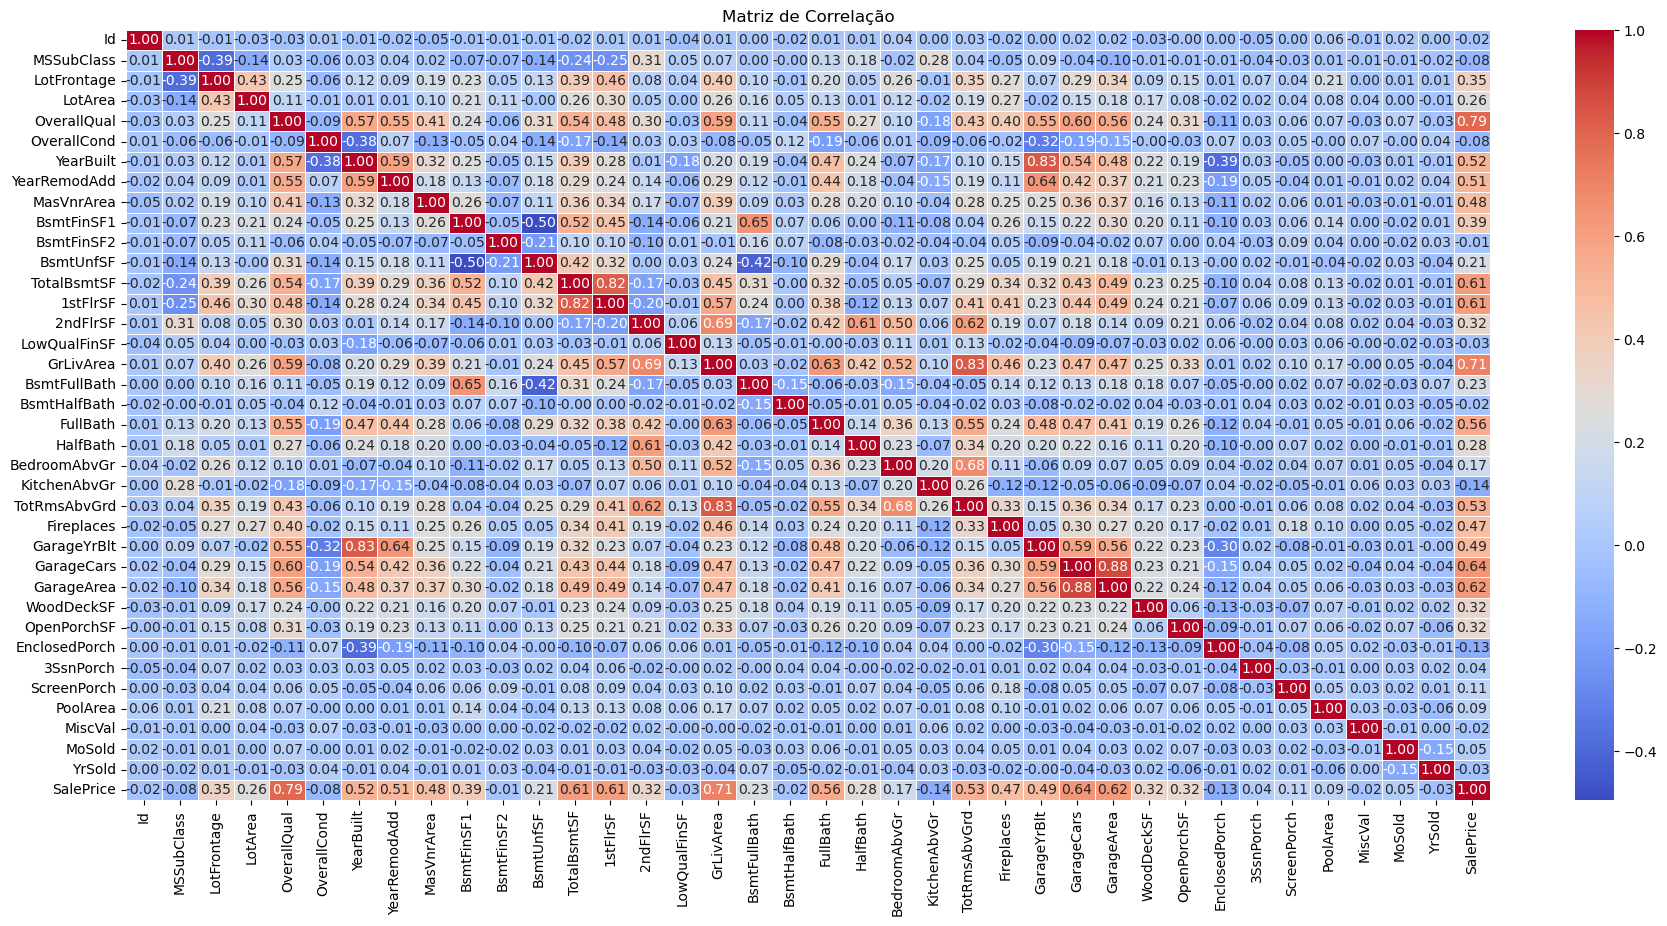

In [9]:
correlation_matrix = train[num_cols].corr()
plt.figure(figsize=(22, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()


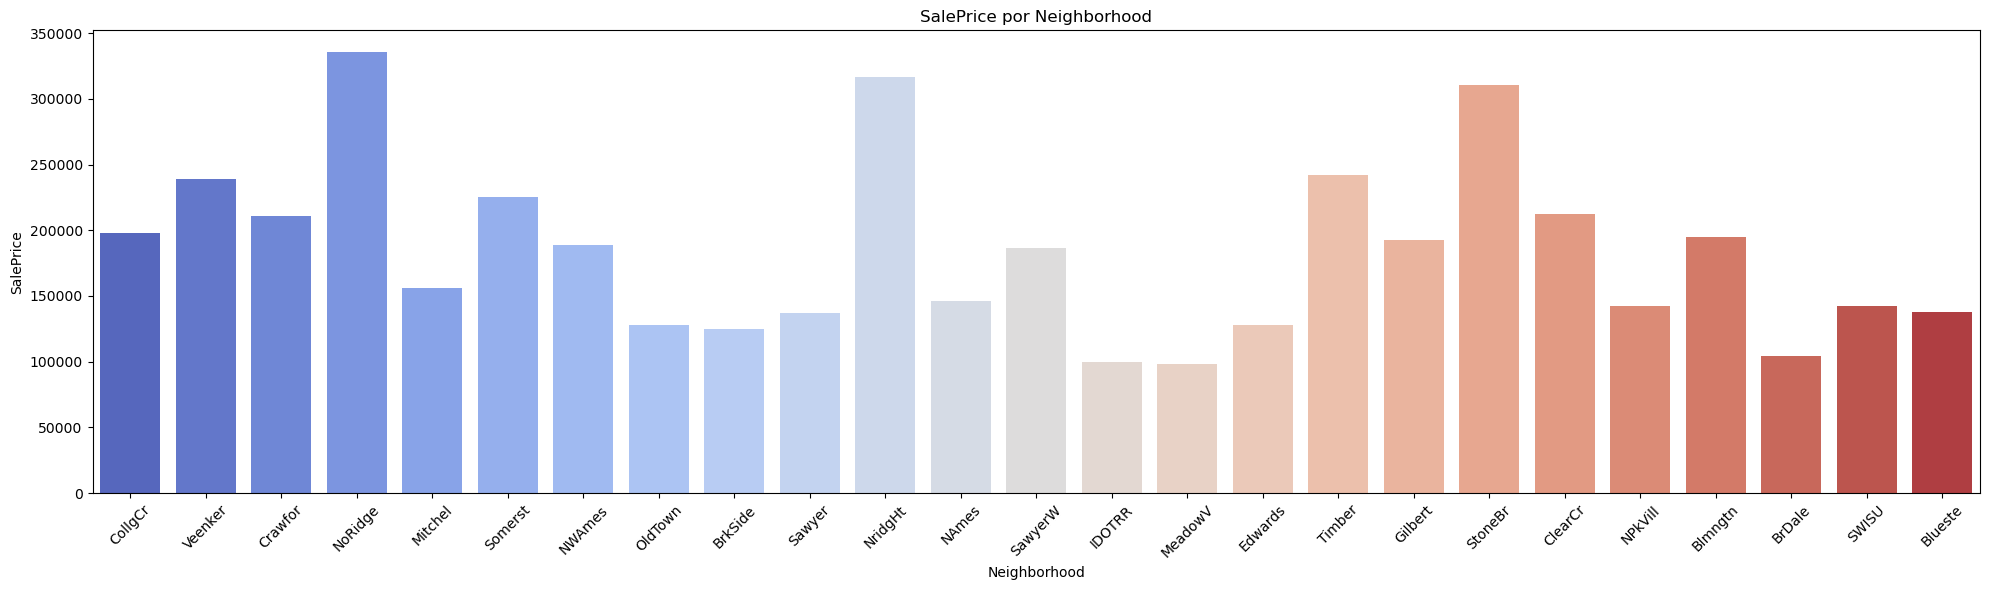

In [10]:
plt.figure(figsize=(20, 6))
sns.barplot(
    x='Neighborhood',
    y='SalePrice',
    hue='Neighborhood',
    data=train,
    palette='coolwarm',
    errorbar=None,
    dodge=False,       
    legend=False       
)
plt.title('SalePrice por Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('SalePrice')
plt.xticks(rotation=45)  # útil se houver muitos bairros
plt.tight_layout()
plt.show()


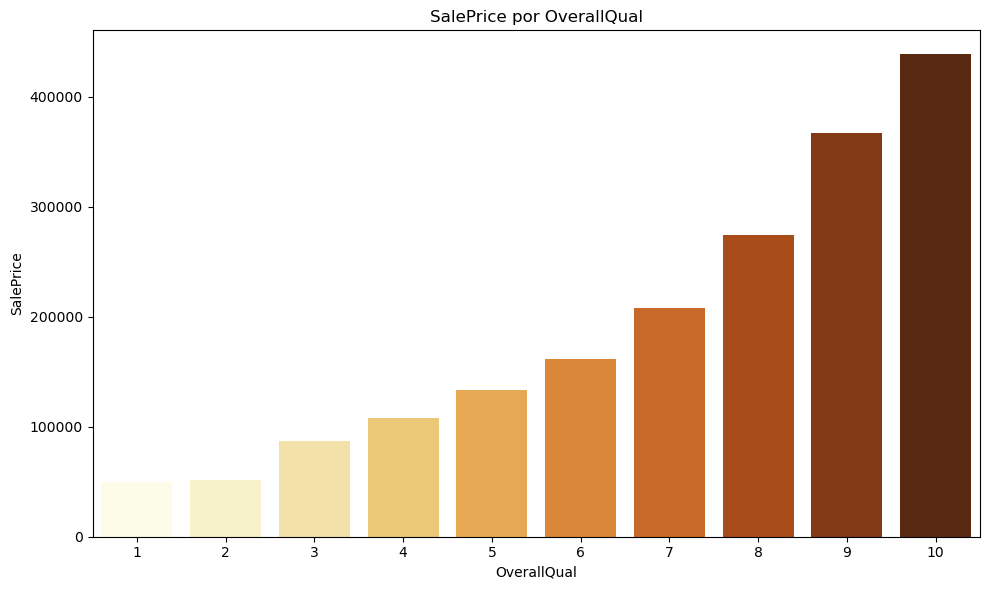

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='OverallQual',
    y='SalePrice',
    hue='OverallQual',
    data=train,
    palette='YlOrBr',
    errorbar=None,
    dodge=False,
    legend=False
)
plt.title('SalePrice por OverallQual')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

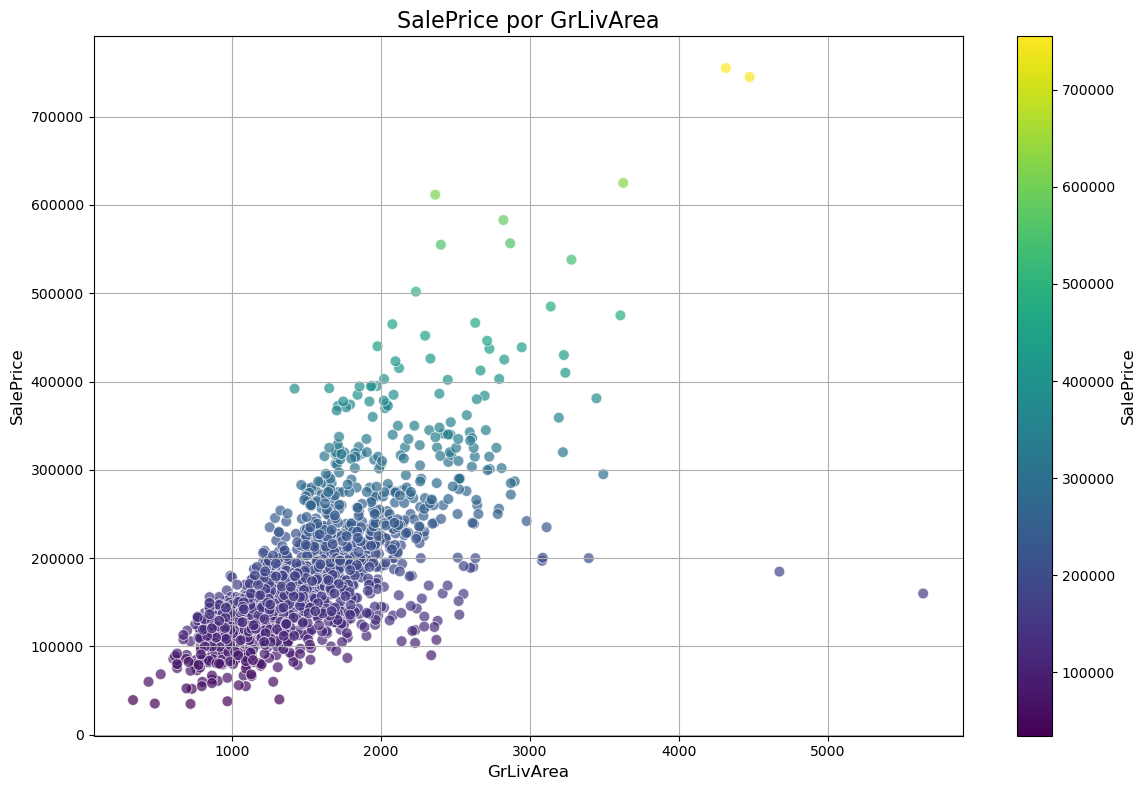

In [12]:
plt.figure(figsize=(12, 8))

# Criar o eixo explicitamente
fig, ax = plt.subplots(figsize=(12, 8))

# Scatterplot com cores baseadas em SalePrice
scatter = sns.scatterplot(
    x='GrLivArea',
    y='SalePrice',
    data=train,
    hue='SalePrice',
    palette='viridis',
    alpha=0.7,
    s=60,
    ax=ax,
    legend=False
)

# Adiciona título e rótulos
ax.set_title('SalePrice por GrLivArea', fontsize=16)
ax.set_xlabel('GrLivArea', fontsize=12)
ax.set_ylabel('SalePrice', fontsize=12)
ax.grid(True)

# Adiciona a barra de cor corretamente vinculada ao eixo
norm = plt.Normalize(train['SalePrice'].min(), train['SalePrice'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array(train['SalePrice'])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('SalePrice', fontsize=12)

plt.tight_layout()
plt.show()

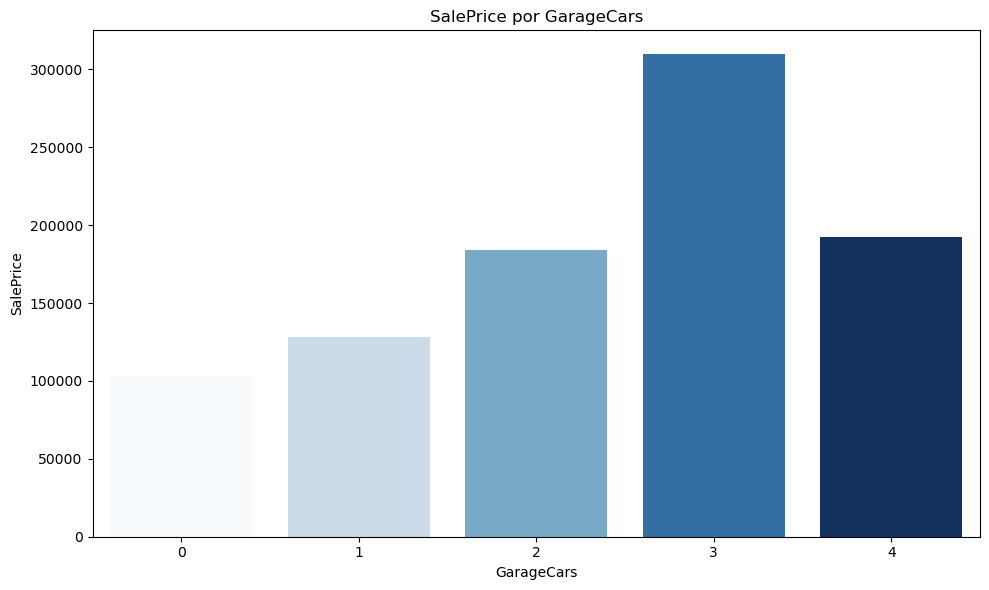

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='GarageCars',
    y='SalePrice',
    hue='GarageCars',      
    data=train,
    palette='Blues',
    errorbar=None,
    dodge=False,           
    legend=False           
)
plt.title('SalePrice por GarageCars')
plt.xlabel('GarageCars')
plt.ylabel('SalePrice')
plt.tight_layout()
plt.show()

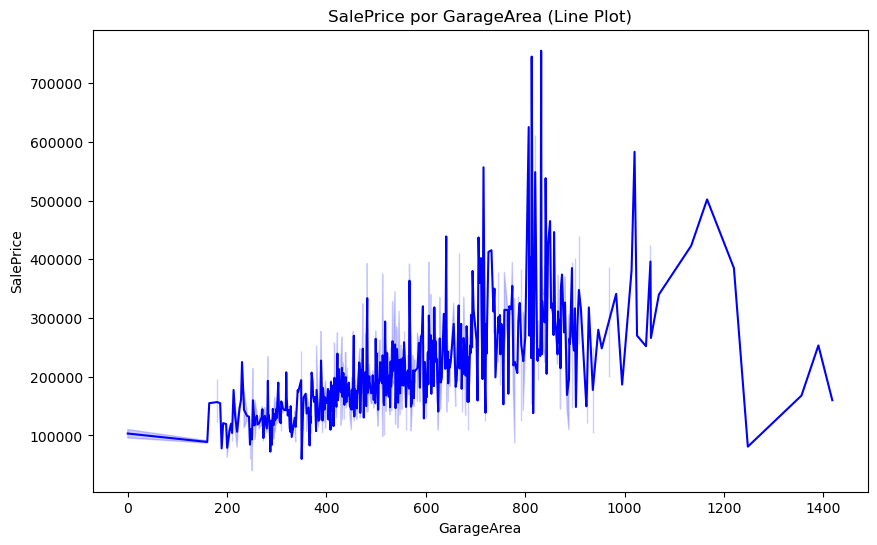

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='GarageArea', y='SalePrice', data=train, color='blue')
plt.title('SalePrice por GarageArea (Line Plot)')
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.show()

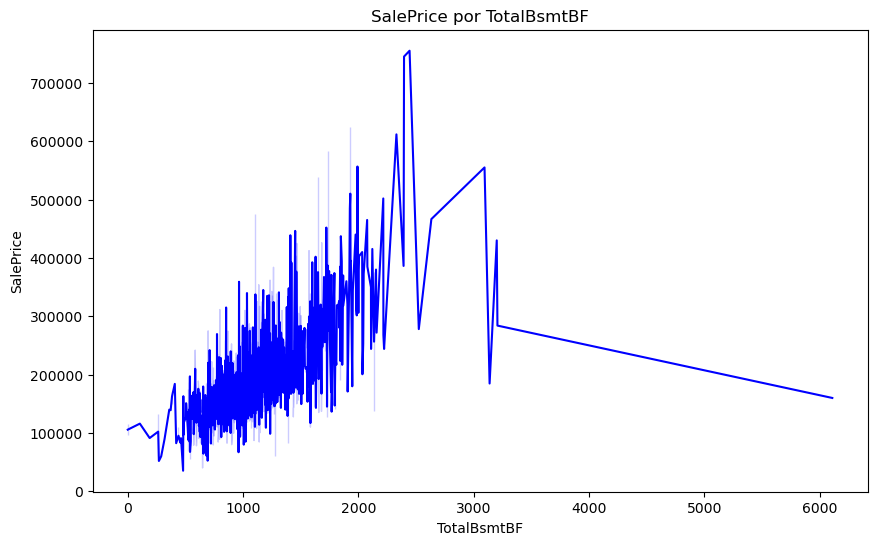

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='TotalBsmtSF', y='SalePrice', data=train, color='blue')
plt.title('SalePrice por TotalBsmtBF')
plt.xlabel('TotalBsmtBF')
plt.ylabel('SalePrice')
plt.show()

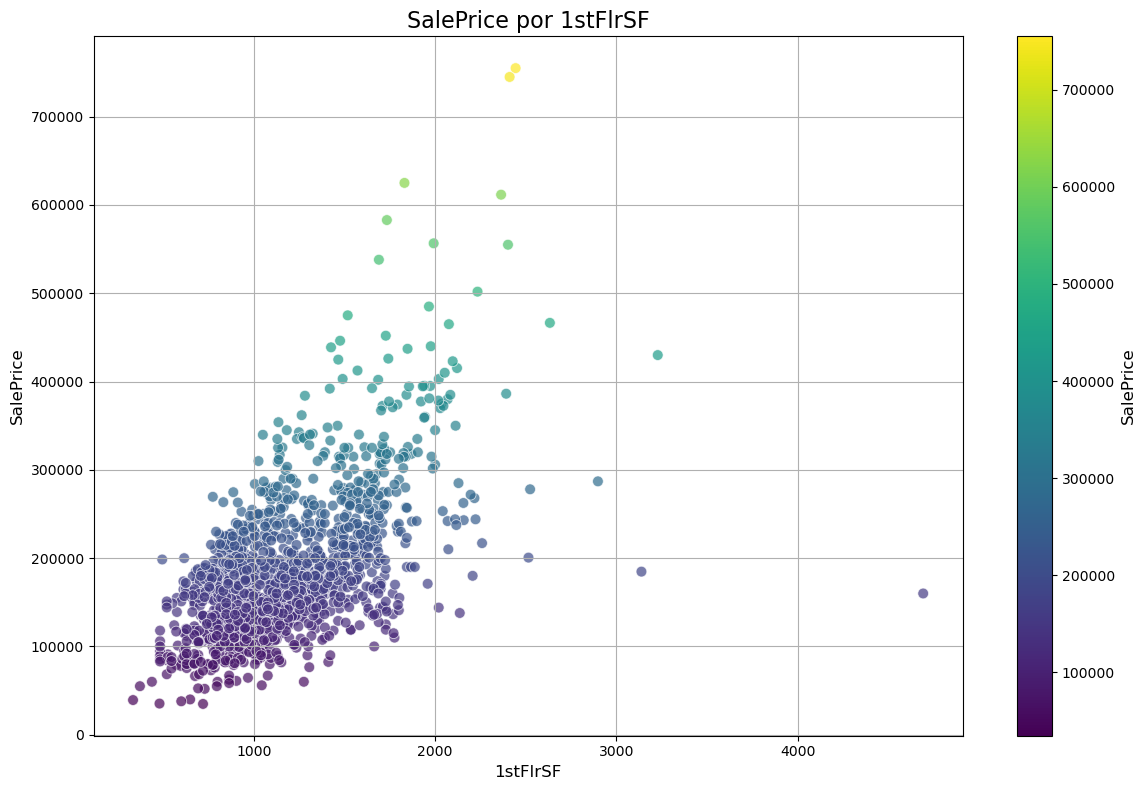

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

scatter = sns.scatterplot(
    x='1stFlrSF',
    y='SalePrice',
    data=train,
    hue='SalePrice',
    palette='viridis',
    alpha=0.7,
    s=60,
    ax=ax,
    legend=False
)

ax.set_title('SalePrice por 1stFlrSF', fontsize=16)
ax.set_xlabel('1stFlrSF', fontsize=12)
ax.set_ylabel('SalePrice', fontsize=12)
ax.grid(True)

# Criar barra de cores associada ao scatterplot
norm = plt.Normalize(train['SalePrice'].min(), train['SalePrice'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array(train['SalePrice'])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('SalePrice', fontsize=12)

plt.tight_layout()
plt.show()


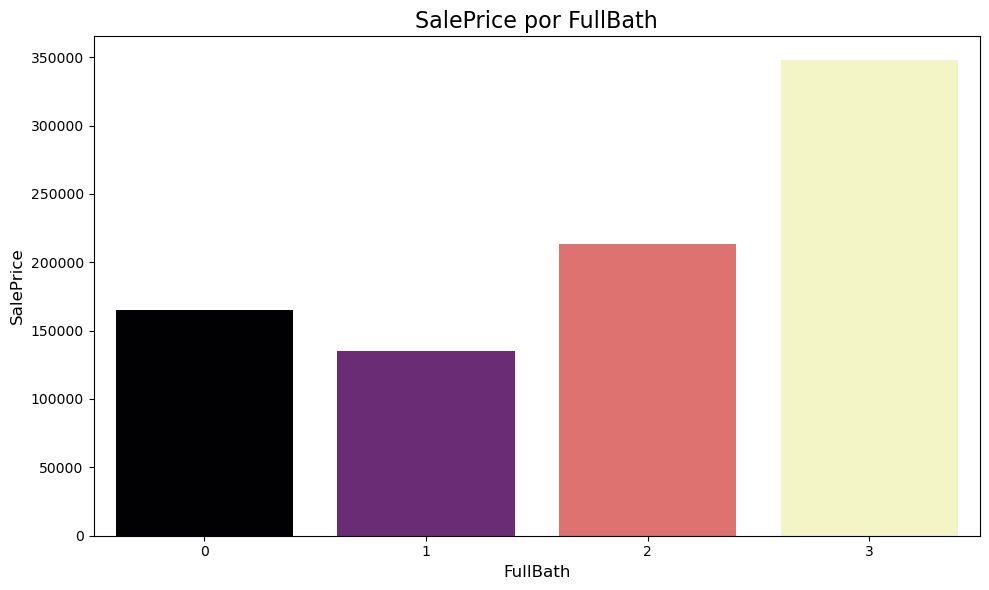

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='FullBath',
    y='SalePrice',
    hue='FullBath',          
    data=train,
    palette='magma',
    errorbar=None,
    dodge=False,             
    legend=False             
)
plt.title('SalePrice por FullBath', fontsize=16)
plt.xlabel('FullBath', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.tight_layout()
plt.show()


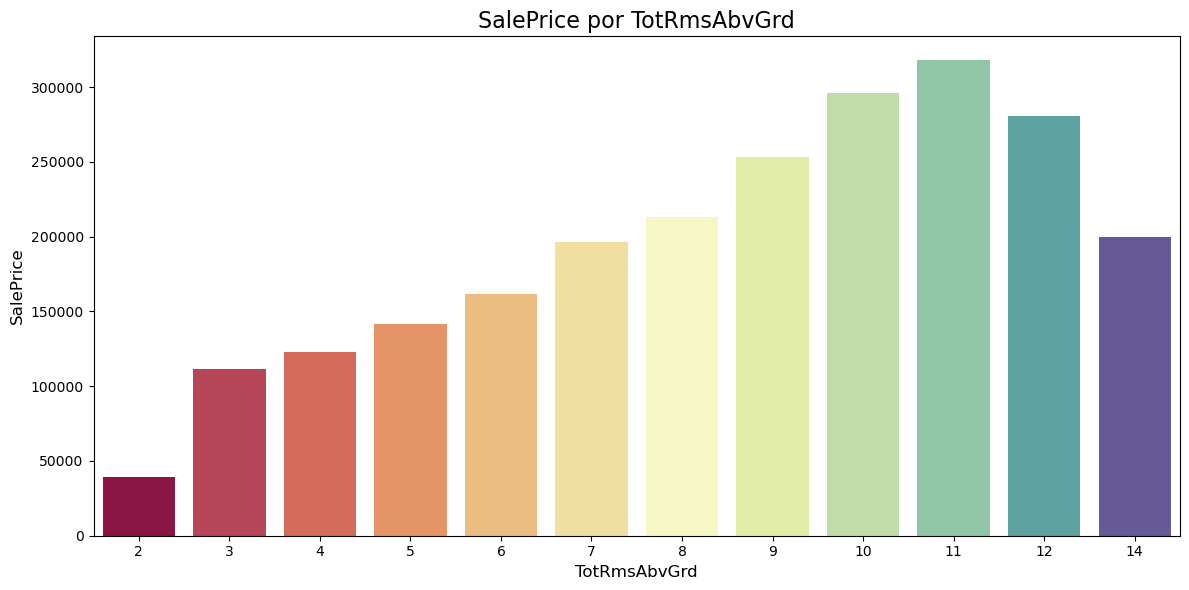

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='TotRmsAbvGrd',
    y='SalePrice',
    hue='TotRmsAbvGrd',   # aplica a paleta por grupo
    data=train,
    palette='Spectral',
    errorbar=None,
    dodge=False,
    legend=False
)
plt.title('SalePrice por TotRmsAbvGrd', fontsize=16)
plt.xlabel('TotRmsAbvGrd', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.tight_layout()
plt.show()

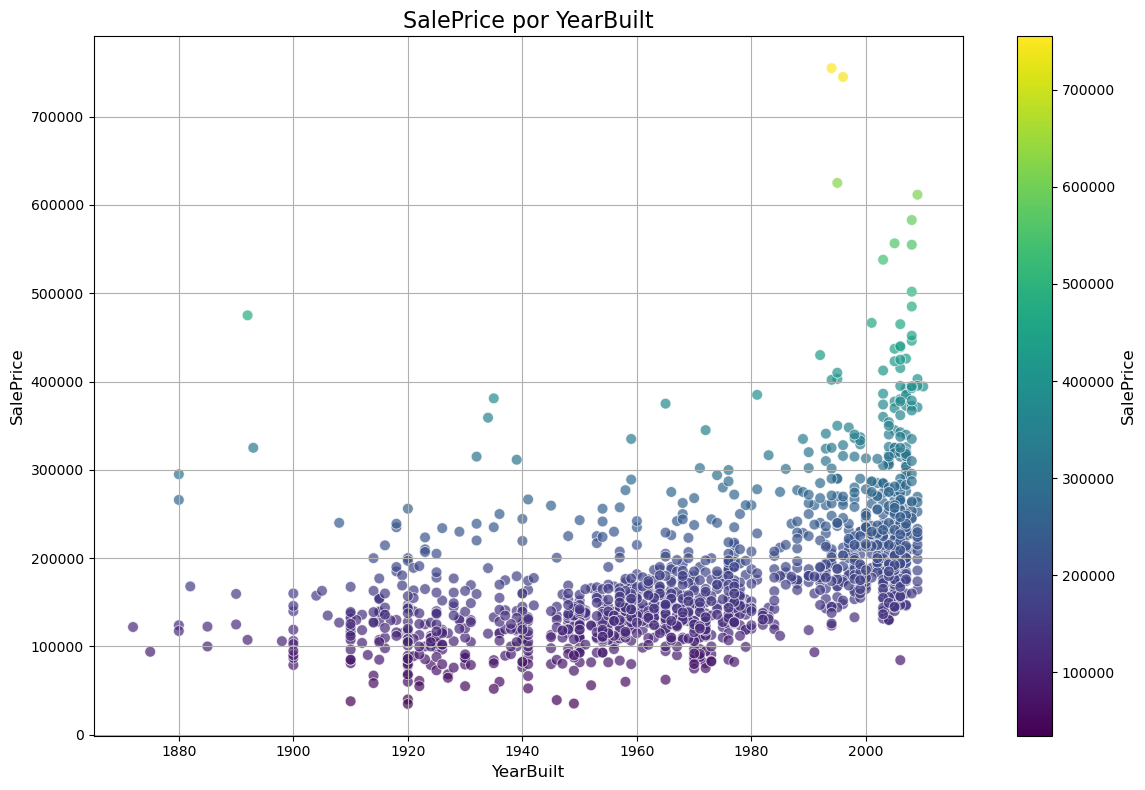

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

# Usar 'viridis' se s_palette não estiver definido
palette_to_use = s_palette if 's_palette' in globals() else 'viridis'

scatter = sns.scatterplot(
    x='YearBuilt',
    y='SalePrice',
    data=train,
    hue='SalePrice',
    palette=palette_to_use,
    alpha=0.7,
    s=60,
    ax=ax,
    legend=False
)

ax.set_title('SalePrice por YearBuilt', fontsize=16)
ax.set_xlabel('YearBuilt', fontsize=12)
ax.set_ylabel('SalePrice', fontsize=12)
ax.grid(True)

norm = plt.Normalize(train['SalePrice'].min(), train['SalePrice'].max())
sm = plt.cm.ScalarMappable(cmap=palette_to_use, norm=norm)
sm.set_array(train['SalePrice'])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('SalePrice', fontsize=12)

plt.tight_layout()
plt.show()

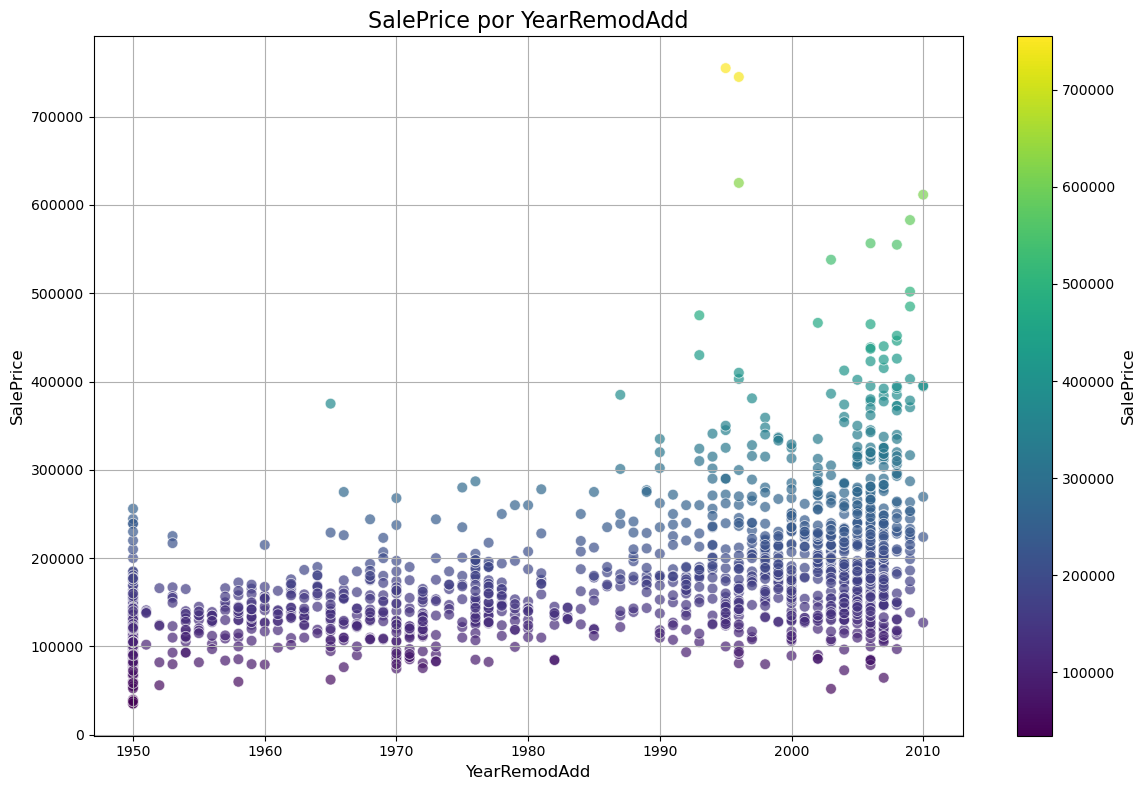

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

palette_to_use = s_palette if 's_palette' in globals() else 'viridis'

scatter = sns.scatterplot(
    x='YearRemodAdd',
    y='SalePrice',
    data=train,
    hue='SalePrice',
    palette=palette_to_use,
    alpha=0.7,
    s=60,
    ax=ax,
    legend=False
)

ax.set_title('SalePrice por YearRemodAdd', fontsize=16)
ax.set_xlabel('YearRemodAdd', fontsize=12)
ax.set_ylabel('SalePrice', fontsize=12)
ax.grid(True)

norm = plt.Normalize(train['SalePrice'].min(), train['SalePrice'].max())
sm = plt.cm.ScalarMappable(cmap=palette_to_use, norm=norm)
sm.set_array(train['SalePrice'])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('SalePrice', fontsize=12)

plt.tight_layout()
plt.show()

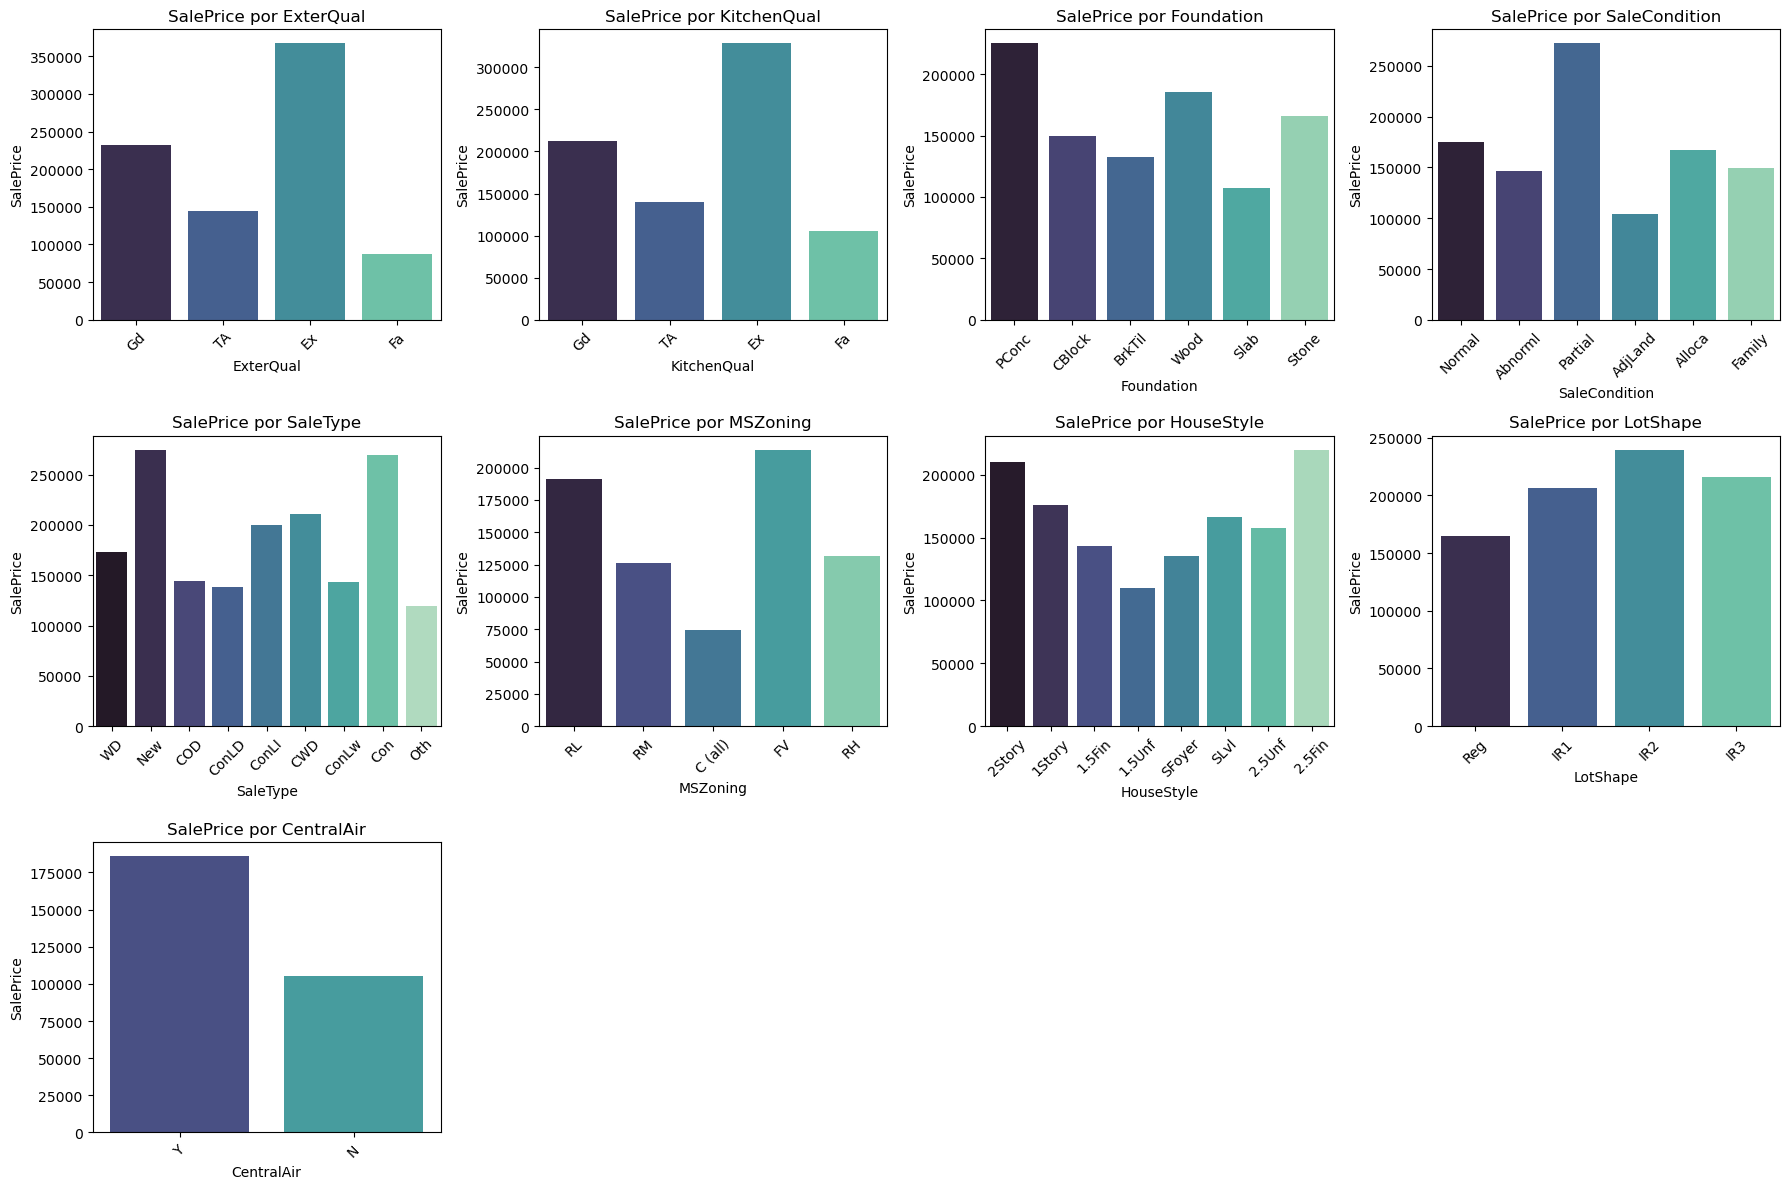

In [21]:
top_cat_cols = [
    'ExterQual', 'KitchenQual', 'Foundation', 
    'SaleCondition', 'SaleType', 'MSZoning', 'HouseStyle', 
    'LotShape', 'CentralAir'
]

filtered_data = train[top_cat_cols + ['SalePrice']]

plt.figure(figsize=(18, 12))
for i, feature in enumerate(top_cat_cols, 1):
    plt.subplot(3, 4, i)
    sns.barplot(
        x=feature,
        y='SalePrice',
        data=filtered_data,
        palette='mako',
        hue=feature,
        legend=False,
        errorbar=None
    )
    plt.title(f'SalePrice por {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
neighborhood_precos = train.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False)

top_neighborhoods = neighborhood_precos.head(5).index.tolist()
print("Bairros com maior preço médio:")
print(top_neighborhoods)

Bairros com maior preço médio:
['NoRidge', 'NridgHt', 'StoneBr', 'Timber', 'Veenker']


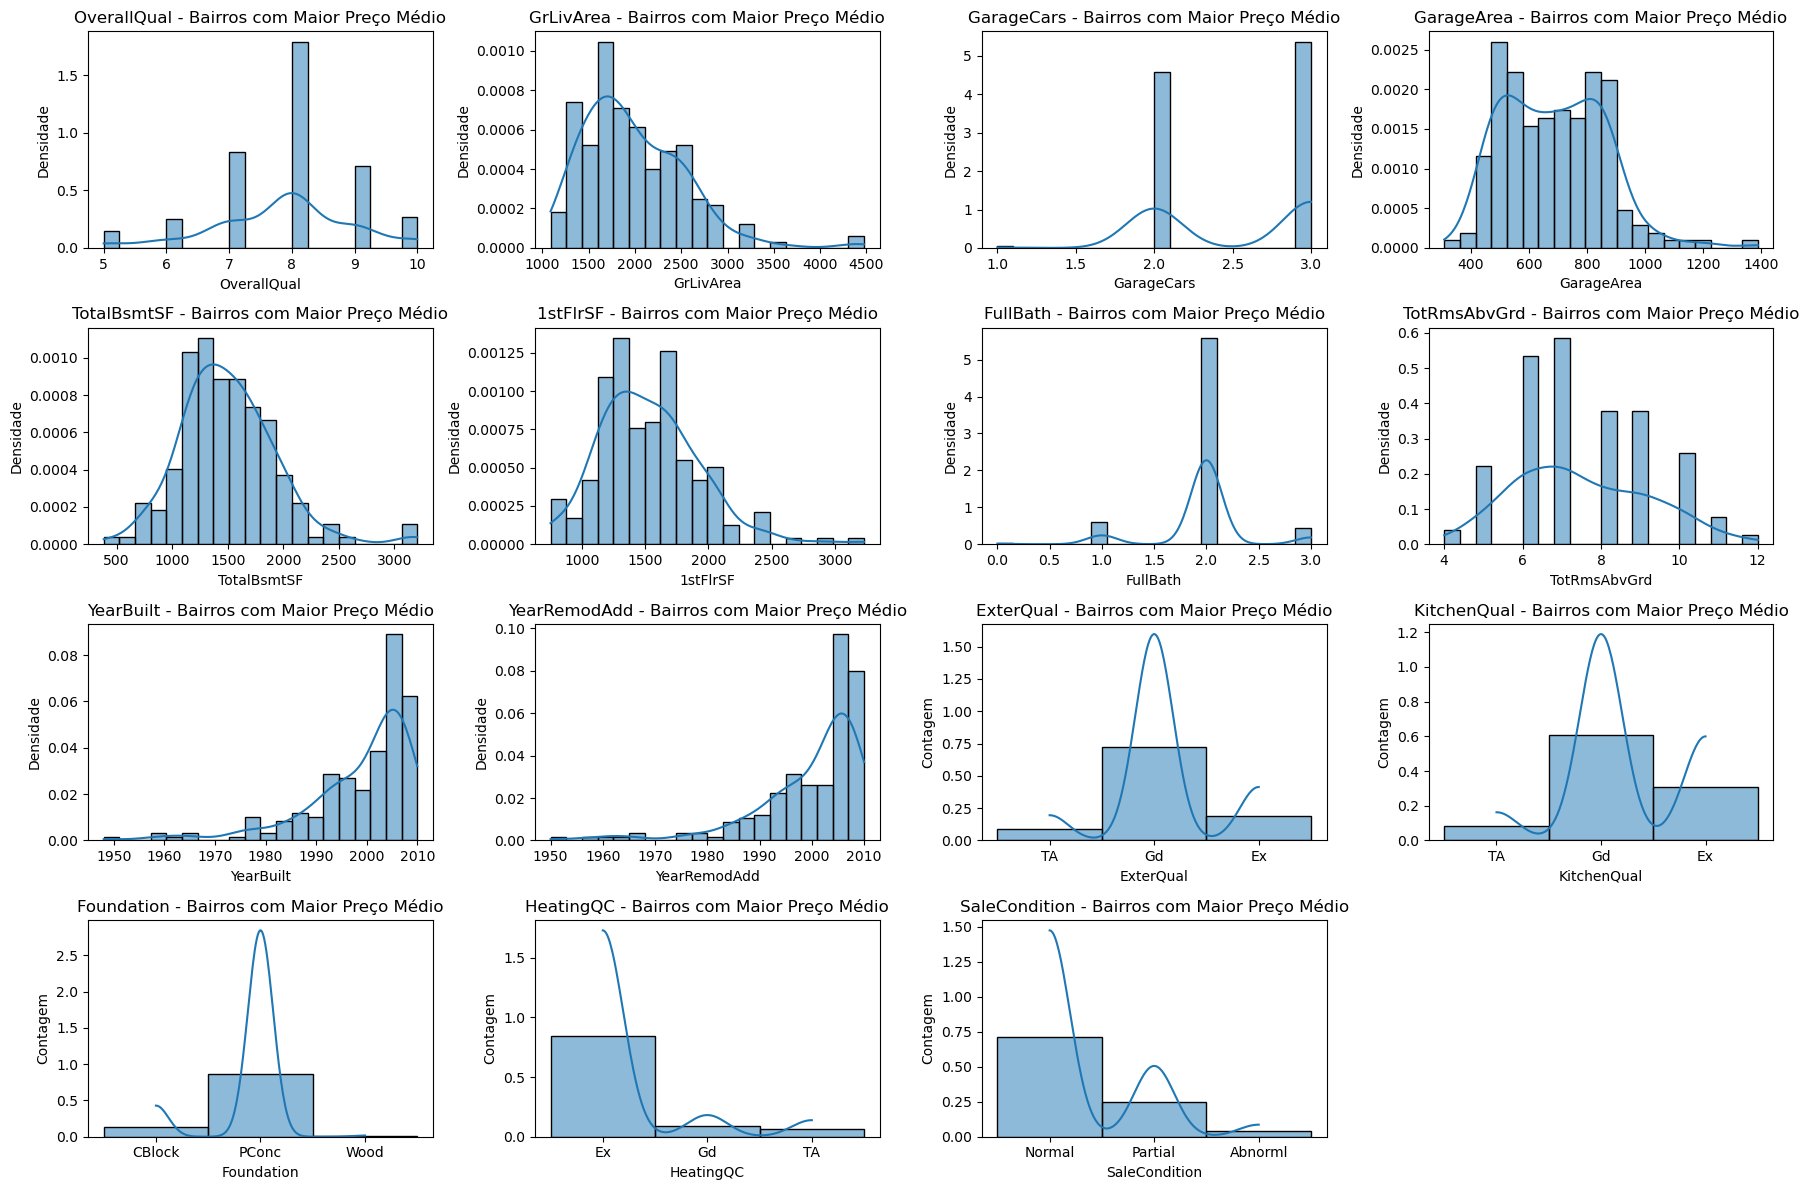

In [23]:
data_filtrada_top = train[train['Neighborhood'].isin(top_neighborhoods)]

variaveis_de_interesse = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd' ,
    'ExterQual', 'KitchenQual', 'Foundation', 'HeatingQC', 'SaleCondition'
]

num_plots = len(variaveis_de_interesse)
rows = (num_plots // 4) + 1

plt.figure(figsize=(18, 12))
for i, feature in enumerate(variaveis_de_interesse, 1):
    plt.subplot(rows, 4, i)
    if train[feature].dtype == 'object':  
        sns.histplot(data_filtrada_top[feature], bins=20, kde=True, stat='density')
        plt.xlabel(feature)
        plt.ylabel('Contagem')
    else:
        sns.histplot(data_filtrada_top[feature], bins=20, kde=True, stat='density')
        plt.xlabel(feature)
        plt.ylabel('Densidade')
    plt.title(f'{feature} - Bairros com Maior Preço Médio')
    
plt.tight_layout()
plt.show()

In [24]:
bottom_neighborhoods = neighborhood_precos.tail(5).index.tolist()
print("Bairros com menor preço médio:")
print(bottom_neighborhoods)

Bairros com menor preço médio:
['Edwards', 'BrkSide', 'BrDale', 'IDOTRR', 'MeadowV']


In [25]:
num_cols.remove('Id') 

shapiro_resultados = {}
for col in num_cols:
    data = train[col].dropna() 
    stat, p_value = shapiro(data)
    shapiro_resultados[col] = {'Estatística': stat, 'Valor p': p_value}

for col, result in shapiro_resultados.items():
    print(f"\nTeste de Shapiro-Wilk para '{col}':")
    print(f"  Estatística: {result['Estatística']}")
    print(f"  Valor p: {result['Valor p']}")


Teste de Shapiro-Wilk para 'MSSubClass':
  Estatística: 0.8045693469226807
  Valor p: 9.108194184864119e-39

Teste de Shapiro-Wilk para 'LotFrontage':
  Estatística: 0.8804028736502089
  Valor p: 2.0016921293556985e-29

Teste de Shapiro-Wilk para 'LotArea':
  Estatística: 0.3510588565706664
  Valor p: 7.933653820088432e-58

Teste de Shapiro-Wilk para 'OverallQual':
  Estatística: 0.9480078212488976
  Valor p: 2.686457143839155e-22

Teste de Shapiro-Wilk para 'OverallCond':
  Estatística: 0.828922876367805
  Valor p: 6.774228909083747e-37

Teste de Shapiro-Wilk para 'YearBuilt':
  Estatística: 0.9255973682459148
  Valor p: 2.770220089996125e-26

Teste de Shapiro-Wilk para 'YearRemodAdd':
  Estatística: 0.8628004084918248
  Valor p: 6.720280883203574e-34

Teste de Shapiro-Wilk para 'MasVnrArea':
  Estatística: 0.6392859612728288
  Valor p: 6.556644985817793e-48

Teste de Shapiro-Wilk para 'BsmtFinSF1':
  Estatística: 0.8479602615555842
  Valor p: 2.813853786170962e-35

Teste de Shapiro-

In [26]:
levene_resultados = {}

for col in num_cols:
    stat, p_value = levene(train[col].dropna(), train['SalePrice'].dropna())
    levene_resultados[col] = {'Estatística': stat, 'Valor p': p_value}

for col, result in levene_resultados.items():
    print(f"\nTeste de Levene para '{col}':")
    print(f"  Estatística: {result['Estatística']}")
    print(f"  Valor p: {result['Valor p']}")


Teste de Levene para 'MSSubClass':
  Estatística: 1268.216282525347
  Valor p: 5.622917120520778e-231

Teste de Levene para 'LotFrontage':
  Estatística: 1043.7025016777357
  Valor p: 1.9114161155541046e-193

Teste de Levene para 'LotArea':
  Estatística: 1083.385070056677
  Valor p: 2.4390012398625687e-202

Teste de Levene para 'OverallQual':
  Estatística: 1269.5824017655857
  Valor p: 3.4918356342315764e-231

Teste de Levene para 'OverallCond':
  Estatística: 1269.5972776410617
  Valor p: 3.473770433153541e-231

Teste de Levene para 'YearBuilt':
  Estatística: 1268.486603292261
  Valor p: 5.1169882941590386e-231

Teste de Levene para 'YearRemodAdd':
  Estatística: 1268.8150090501392
  Valor p: 4.563228502936302e-231

Teste de Levene para 'MasVnrArea':
  Estatística: 1257.950054597279
  Valor p: 2.5514914300002024e-229

Teste de Levene para 'BsmtFinSF1':
  Estatística: 1252.9900877921834
  Valor p: 1.1499094967474887e-228

Teste de Levene para 'BsmtFinSF2':
  Estatística: 1267.49461

In [27]:
null_indicatores_num = train[num_cols].isnull().astype(int)
null_indicatores_num['SalePrice'] = train['SalePrice']

null_correlacao = null_indicatores_num.corr()['SalePrice'].sort_values(ascending=False)

maiores_corr_numer = null_correlacao.head(10) 
menores_corr_numer = null_correlacao.tail(10)

print("Top 10 maiores correlações entre valores nulos e SalePrice:\n", maiores_corr_numer)
print("\nTop 10 menores correlações entre valores nulos e SalePrice:\n", menores_corr_numer)

Top 10 maiores correlações entre valores nulos e SalePrice:
 SalePrice       1.000000
MasVnrArea      0.051933
LotFrontage     0.004087
GarageYrBlt    -0.236832
MSSubClass           NaN
LotArea              NaN
OverallQual          NaN
OverallCond          NaN
YearBuilt            NaN
YearRemodAdd         NaN
Name: SalePrice, dtype: float64

Top 10 menores correlações entre valores nulos e SalePrice:
 GarageArea      NaN
WoodDeckSF      NaN
OpenPorchSF     NaN
EnclosedPorch   NaN
3SsnPorch       NaN
ScreenPorch     NaN
PoolArea        NaN
MiscVal         NaN
MoSold          NaN
YrSold          NaN
Name: SalePrice, dtype: float64


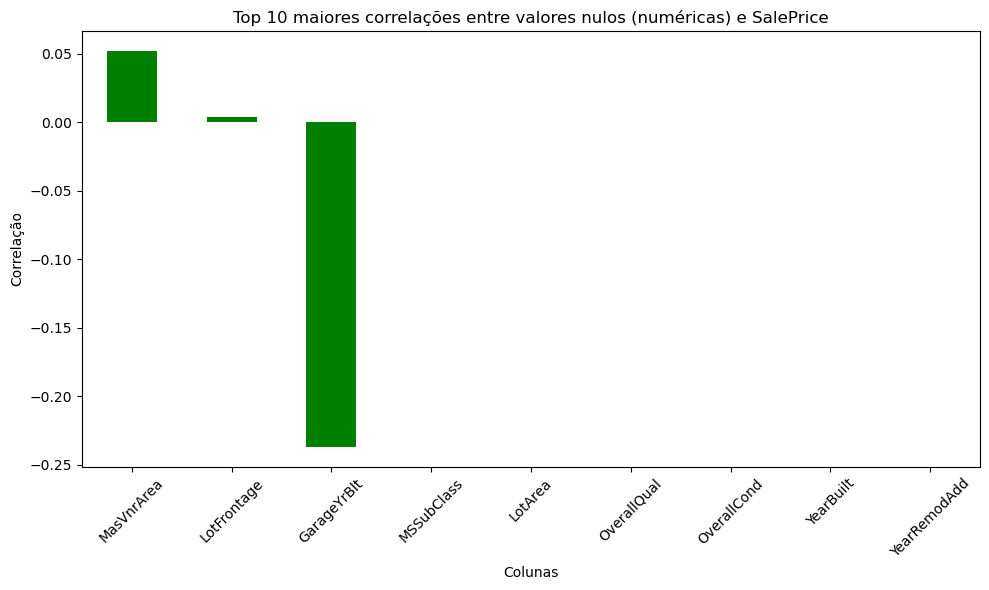

In [28]:
plt.figure(figsize=(10, 6))
maiores_corr_numer[1:].plot(kind='bar', color='green')
plt.title('Top 10 maiores correlações entre valores nulos (numéricas) e SalePrice')
plt.ylabel('Correlação')
plt.xlabel('Colunas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
null_indicatores_cat = train[cat_cols].isnull().astype(int)
null_indicatores_cat['SalePrice'] = train['SalePrice']

null_correlacao_cat = null_indicatores_cat.corr()['SalePrice'].sort_values(ascending=False)

maiores_corr_cat = null_correlacao_cat.head(20)
menores_corr_cat = null_correlacao_cat.tail(10)

print("Maiores correlações entre valores nulos (categóricas) e SalePrice:\n", maiores_corr_cat)
print("\nMenores correlações entre valores nulos (categóricas) e SalePrice:\n", menores_corr_cat)

Maiores correlações entre valores nulos (categóricas) e SalePrice:
 SalePrice       1.000000
Fence           0.172184
Alley           0.123611
MiscFeature     0.072298
Electrical     -0.004424
PoolQC         -0.093708
BsmtFinType2   -0.145274
BsmtExposure   -0.150231
BsmtCond       -0.152829
BsmtFinType1   -0.152829
BsmtQual       -0.152829
GarageType     -0.236832
GarageFinish   -0.236832
GarageQual     -0.236832
GarageCond     -0.236832
MasVnrType     -0.367456
FireplaceQu    -0.471908
MSZoning             NaN
Street               NaN
LotShape             NaN
Name: SalePrice, dtype: float64

Menores correlações entre valores nulos (categóricas) e SalePrice:
 ExterCond       NaN
Foundation      NaN
Heating         NaN
HeatingQC       NaN
CentralAir      NaN
KitchenQual     NaN
Functional      NaN
PavedDrive      NaN
SaleType        NaN
SaleCondition   NaN
Name: SalePrice, dtype: float64


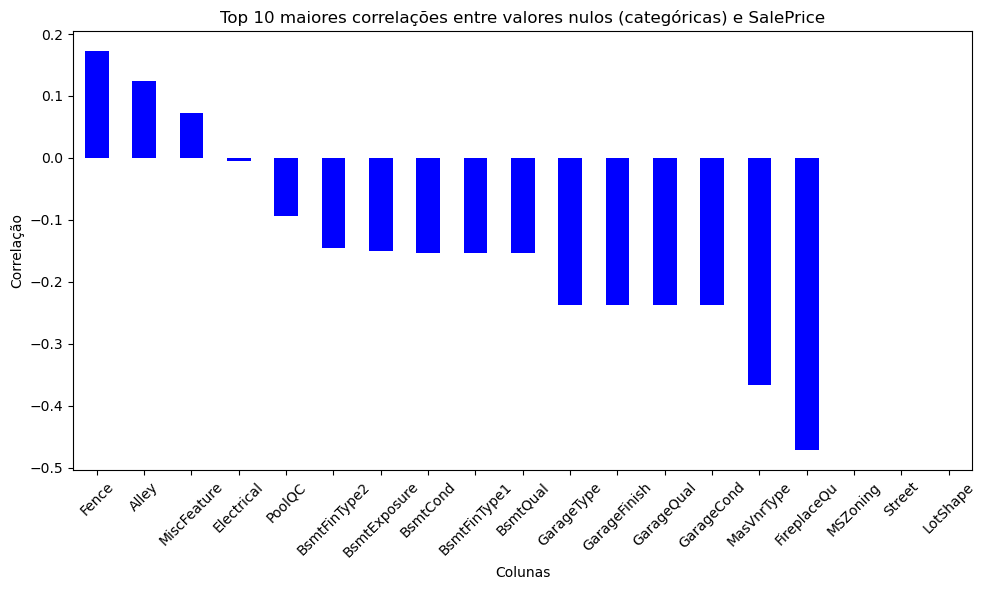

In [30]:
plt.figure(figsize=(10, 6))
maiores_corr_cat[1:].plot(kind='bar', color='blue')
plt.title('Top 10 maiores correlações entre valores nulos (categóricas) e SalePrice')
plt.ylabel('Correlação')
plt.xlabel('Colunas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
le = OrdinalEncoder()
for column in cat_cols:
    train[f"{column}_le"] = le.fit_transform(train[column].values.reshape(-1, 1))

for column in cat_cols:
    print(column)
    print(train[column].unique())
    print(train[f"{column}_le"].unique())
    print()   

MSZoning
['RL' 'RM' 'C (all)' 'FV' 'RH']
[3. 4. 0. 1. 2.]

Street
['Pave' 'Grvl']
[1. 0.]

Alley
[nan 'Grvl' 'Pave']
[nan  0.  1.]

LotShape
['Reg' 'IR1' 'IR2' 'IR3']
[3. 0. 1. 2.]

LandContour
['Lvl' 'Bnk' 'Low' 'HLS']
[3. 0. 2. 1.]

Utilities
['AllPub' 'NoSeWa']
[0. 1.]

LotConfig
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
[4. 2. 0. 1. 3.]

LandSlope
['Gtl' 'Mod' 'Sev']
[0. 1. 2.]

Neighborhood
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
[ 5. 24.  6. 15. 11. 21. 14. 17.  3. 19. 16. 12. 20.  9. 10.  7. 23.  8.
 22.  4. 13.  0.  2. 18.  1.]

Condition1
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
[2. 1. 4. 0. 5. 8. 6. 3. 7.]

Condition2
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
[2. 0. 7. 1. 4. 3. 6. 5.]

BldgType
['1Fam' '2fmCon' 'Duplex' 'TwnhsE'

In [32]:
# Normalização de variáveis numéricas
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])

### ⚙️ Engenharia de Features

In [33]:
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
train['Alley'] = train['Alley'].fillna('None')
train['PoolQC'] = train['PoolQC'].fillna('None')
train['Fence'] = train['Fence'].fillna('None')
train['MiscFeature'] = train['MiscFeature'].fillna('None')

In [34]:
# Selecionando features e target
features = train.columns.tolist()
target = 'SalePrice'

X = train[features]
y = train[target]

# Codificando variáveis categóricas
cat_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
num_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Separando variáveis numéricas e categóricas
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

In [35]:
# Criação de nova feature (ÁREA TOTAL DA CASA)
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

In [36]:
# Seleção de features numéricas com alta correlação
num_features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
    'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 
    'YearBuilt', 'YearRemodAdd'
]

# Seleção de features categóricas com alta correlação
cat_features = [
    'Neighborhood', 'ExterQual', 'KitchenQual', 'Foundation', 
    'SaleCondition', 'SaleType', 'MSZoning', 'HouseStyle', 
    'LotShape', 'CentralAir'
]

# Combinar features numéricas e categóricas
selected_features = num_features + cat_features
X = train[selected_features]
y = train['SalePrice']

# Pré-processamento para dados numéricos: imputação de valores ausentes e normalização
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pré-processamento para dados categóricos: imputação de valores ausentes e codificação one-hot
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

## 2. Aprendizagem Supervisionada: Modelos de Regressão
### 🌳 Random Forest Regressor

In [37]:
# Combinar etapas de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Criar um pipeline que inclui pré-processamento e o modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [38]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Treinar o modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['OverallQual', 'GrLivArea',
                                                   'GarageCars', 'GarageArea',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   'FullBath', 'TotRmsAbvGrd',
                                                   'YearBuilt',
                                                   'YearRemodAdd']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Neighborhood', 'ExterQual',
                                                   'KitchenQual', 'Foundation',
                                                   'SaleCondition', 'SaleType',
                                                   'MSZoning', 'HouseStyle',
                                                   'LotShape',
                                                   'CentralAir'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [40]:
# Avaliar o modelo
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 0.14891624561783848
Root Mean Squared Error: 0.38589667738636785


In [41]:
# Cross-validation score
cv_score = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_score)
print("Cross-validated RMSE:", cv_rmse.mean())

Cross-validated RMSE: 0.39382418778418227


In [42]:
X = train[num_features + cat_features]
y = train['SalePrice']

# Pré-processamento para dados numéricos: imputação de valores ausentes e normalização
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pré-processamento para dados categóricos: imputação de valores ausentes e codificação one-hot
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar etapas de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Criar um pipeline que inclui pré-processamento e o modelo de regressão linear
pipeline_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
pipeline_reg.fit(X_train, y_train)

# Fazer previsões
y_pred_reg = pipeline_reg.predict(X_test)

# Avaliar o desempenho do modelo
mse_reg = mean_squared_error(y_test, y_pred_reg)
rmse_reg = np.sqrt(mse_reg)
print(f"Mean Squared Error (Regressão Linear): {mse_reg}")
print(f"Root Mean Squared Error (Regressão Linear): {rmse_reg}")

Mean Squared Error (Regressão Linear): 0.18102557118980817
Root Mean Squared Error (Regressão Linear): 0.42547099923474


In [43]:
# Definindo um limiar para determinar se o preço de venda é alto ou baixo
threshold = np.percentile(train['SalePrice'], 75)  # preço acima do 75º percentil é considerado alto

# Criando a variável binária de saída
train['SalePrice_bin'] = train['SalePrice'].apply(lambda x: 1 if x >= threshold else 0)

# Verificando o balanceamento das classes
print(train['SalePrice_bin'].value_counts())

SalePrice_bin
0    1093
1     367
Name: count, dtype: int64


In [44]:
# Selecionar as mesmas features usadas na regressão linear
X = train[num_features + cat_features]
y_bin = train['SalePrice_bin']

# Combinar etapas de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Criar um pipeline que inclui pré-processamento e o modelo de classificação (Logistic Regression)
pipeline_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Treinar o modelo
pipeline_clf.fit(X_train, y_train)

# Fazer previsões
y_pred_clf = pipeline_clf.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred_clf)
print(f"Acurácia do modelo de classificação: {accuracy:.2f}")

# Mostrar relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_clf))

Acurácia do modelo de classificação: 0.92

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       222
           1       0.86      0.81      0.84        70

    accuracy                           0.92       292
   macro avg       0.90      0.89      0.89       292
weighted avg       0.92      0.92      0.92       292



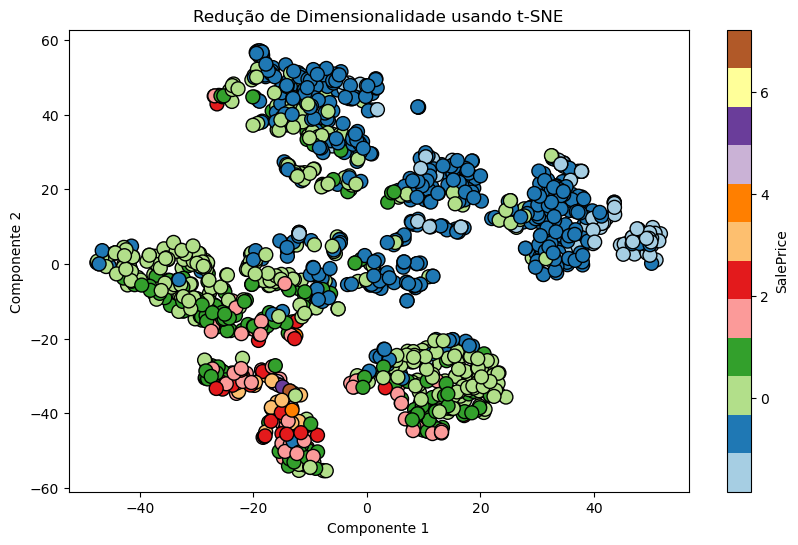

In [45]:
#Redução de dimensionalidade nº 2
X_not_scaled = train[num_features]
X_scaled = scaler.fit_transform(X_not_scaled)

# Aplicar t-SNE para 2 componentes
tsne = TSNE(n_components=2, init='random', learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Criar um DataFrame com os resultados do t-SNE
df_tsne = pd.DataFrame(X_tsne, columns=['Componente 1', 'Componente 2'])

# Adicionar a variável 'SalePrice' ao DataFrame
df_tsne['SalePrice'] = y

# Criar um gráfico de dispersão 2D
plt.figure(figsize=(10, 6))
plt.scatter(df_tsne['Componente 1'], df_tsne['Componente 2'], c=df_tsne['SalePrice'], cmap='Paired', edgecolor='k', s=100)
plt.colorbar(label='SalePrice')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Redução de Dimensionalidade usando t-SNE')
plt.show()

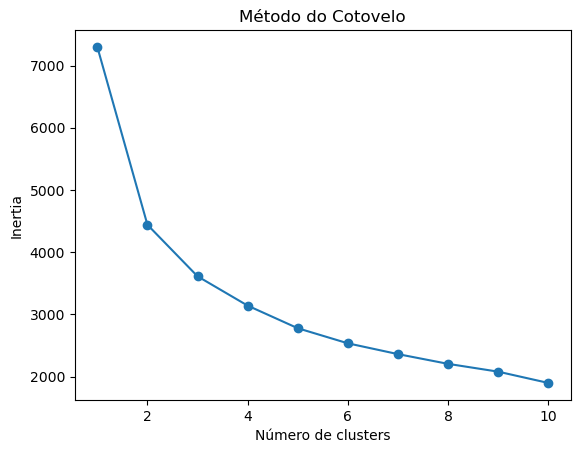

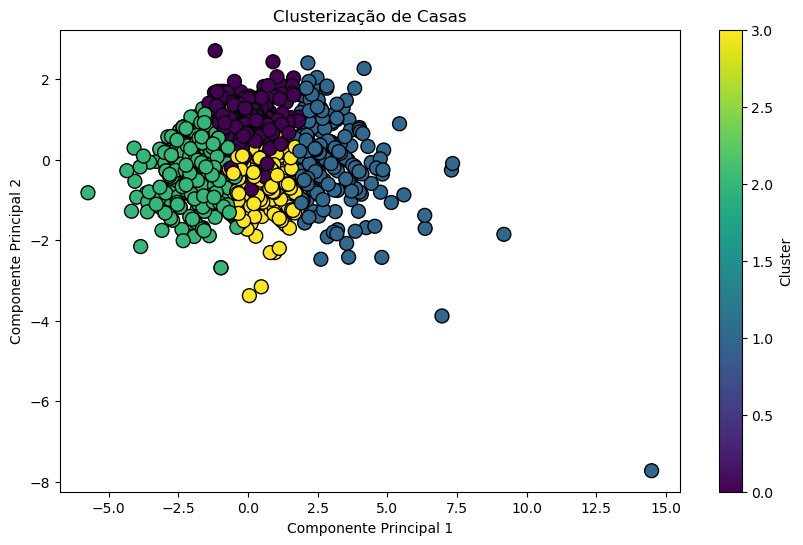

In [46]:
#Kmeans Versão 2 
features_selecionadas = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']
X_cluster = train[features_selecionadas]

#Normalização dos dados
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

#Escolher o número de clusters usando o método do cotovelo
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo')
plt.show()

#Escolha do nº de  clusters
n_clusters = 4

#Aplicar o K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_cluster_scaled)

#Adicionar os clusters de volta ao DataFrame original
train['Cluster'] = clusters

#Visualização dos clusters em um espaço de menor dimensão (reduzido usando PCA)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', edgecolor='k', s=100)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusterização de Casas')
plt.colorbar(label='Cluster')
plt.show()

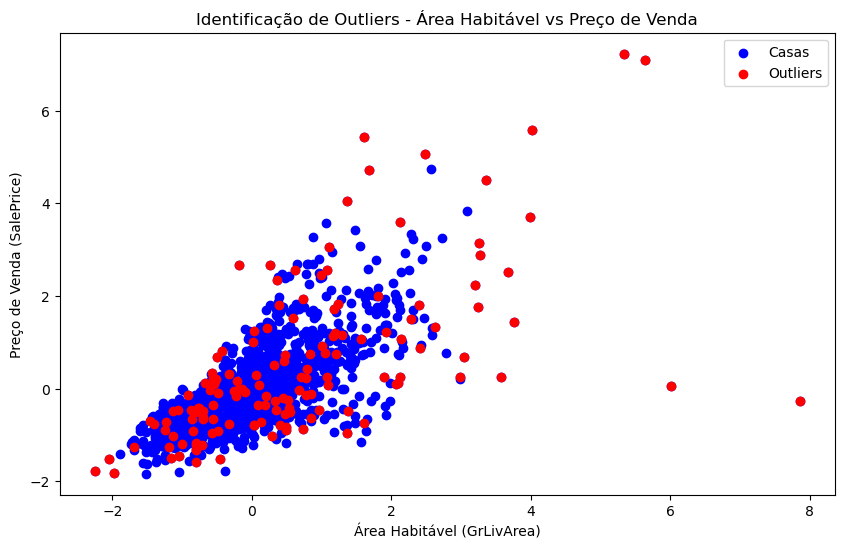

In [47]:
X = train[num_features].copy()
X['SalePrice'] = train['SalePrice']  
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Criação de uma instância do algoritmo LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# Ajuste do modelo aos dados e previsão dos rótulos dos outliers
y_pred = lof.fit_predict(X_scaled)

# Identificação dos outliers
outliers = X[y_pred == -1]

# Visualização dos outliers
plt.figure(figsize=(10, 6))

# Scatter plot das casas
plt.scatter(X['GrLivArea'], X['SalePrice'], color='blue', label='Casas')
# Scatter plot dos outliers
plt.scatter(outliers['GrLivArea'], outliers['SalePrice'], color='red', label='Outliers')

plt.title('Identificação de Outliers - Área Habitável vs Preço de Venda')
plt.xlabel('Área Habitável (GrLivArea)')
plt.ylabel('Preço de Venda (SalePrice)')
plt.legend()
plt.show()

In [48]:
cat_association = ['Neighborhood', 'ExterQual', 'KitchenQual', 'Foundation', 
    'SaleCondition', 'SaleType', 'MSZoning', 'HouseStyle', 
    'LotShape', 'CentralAir']


# Filtrar o dataframe apenas com as colunas categóricas
train_cat = train[cat_association].copy()

# Preencher valores nulos (se houver) com uma categoria 'Desconhecido'
train_cat.fillna('Desconhecido', inplace=True)

# Transformar os dados em um formato de lista de listas (uma lista para cada linha)
transactions = train_cat.values.tolist()

# Instanciar um objeto TransactionEncoder
te = TransactionEncoder()

# Transformar os dados no formato de matriz binária
te_ary = te.fit(transactions).transform(transactions)

# Criar um dataframe de pandas com a matriz, onde as colunas são os itens únicos
encoded_df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(encoded_df, min_support=0.01, use_colnames=True, max_len=2)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)


# Exibir as regras encontradas
print(rules[['antecedents', 'consequents', 'support', 'confidence']])

    antecedents consequents   support  confidence
0      (1.5Fin)    (Normal)  0.092466    0.876623
1      (1.5Fin)        (RL)  0.064384    0.610390
2      (1.5Fin)       (Reg)  0.083562    0.792208
3      (1.5Fin)        (TA)  0.096575    0.915584
4      (1.5Fin)        (WD)  0.097945    0.928571
..          ...         ...       ...         ...
286         (Y)        (TA)  0.589041    0.630037
287    (Timber)        (WD)  0.019863    0.763158
288    (Timber)         (Y)  0.026027    1.000000
289        (WD)         (Y)  0.808219    0.931334
290         (Y)        (WD)  0.808219    0.864469

[291 rows x 4 columns]


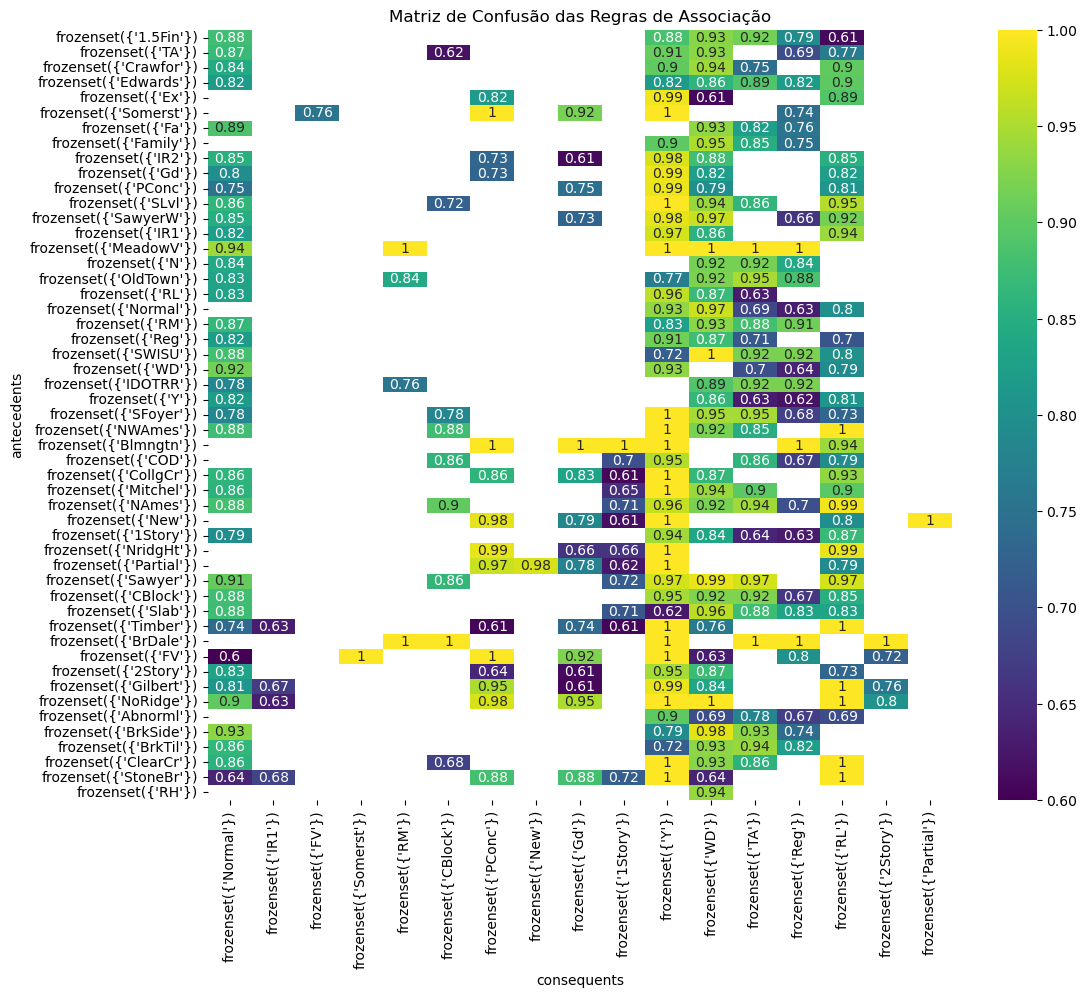

In [49]:
# Criar uma matriz de confusão
pivot_table = rules.pivot(index='antecedents', columns='consequents', values='confidence')

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, annot=True, cmap='viridis', cbar=True)
plt.title('Matriz de Confusão das Regras de Associação')
plt.show()